# HW 29

In [1]:
# import jax
# import jax.numpy as jnp
import numpy as np
import pandas as pd
# import PIL
# import scipy
# import sympy as sp
from matplotlib import pyplot as plt
from scipy.optimize import minimize

<img src="fig_29_intro.png" alt="formula" width="900">

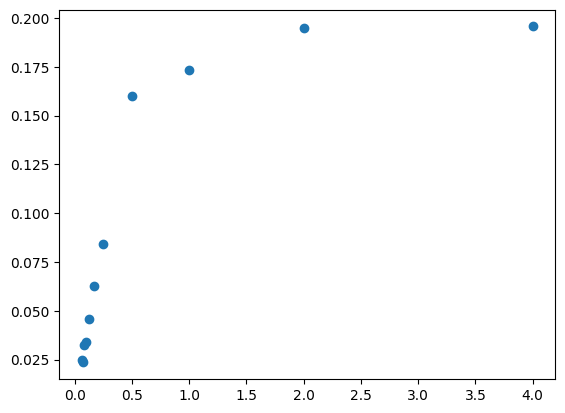

In [2]:
data: pd.DataFrame = pd.read_csv("aer.txt", delimiter=r'\s+', header=None).values # type: ignore
enzy: np.ndarray = data[:, 0] # type: ignore
rate: np.ndarray = data[:, 1] # type: ignore

plt.scatter(enzy, rate)

In [3]:
def f(theta: np.ndarray, u: float):
    assert isinstance(theta, np.ndarray) and len(theta.shape)==1 and theta.shape[0]==4
    assert isinstance(u, float)
    th1, th2, th3, th4 = theta
    numerator = th1*(u**2+th2*u)
    denominator = u**2+th3*u+th4
    return numerator/denominator

def f_vec(theta: np.ndarray, u: np.ndarray):
    return np.array([f(theta, v) for v in u])

# NOTE: theta_log = np.array([np.log(th) for th in theta])

In [4]:
# a. Which parameters could go to zero without resulting in a trivial model? Rewrite the model
# for each of these cases.

# theta1*theta2 is identifiable but theta1/theta2 is unidentifiable: theta2 is
# similarly unidentifiable

# All parameters except for theta1 could go to zero without resulting in a trivial model.
# In each case, associated values simplify to zero

# drop th2
# drop th3
# drop th4
# drop th2 & th3
# drop th2 & th4
# drop th3 & th4
# drop th2 & th3 & th4

# drop th2
def f_drop2(theta: np.ndarray, u: float):
    th1, _, th3, th4 = theta
    numerator = th1*u**2
    denominator = u**2+th3*u+th4
    return numerator/denominator

# drop th3
def f_drop3(theta: np.ndarray, u: float):
    th1, th2, _, th4 = theta
    numerator = th1*(u**2+th2*u)
    denominator = u**2+th4
    return numerator/denominator

# drop th4
def f_drop4(theta: np.ndarray, u: float):
    th1, th2, th3, _ = theta
    numerator = th1*(u**2+th2*u)
    denominator = u**2+th3*u
    return numerator/denominator

# drop th2 & th3
def f_drop23(theta: np.ndarray, u: float):
    th1, _, _, th4 = theta
    numerator = th1*u**2
    denominator = u**2+th4
    return numerator/denominator

# drop th2 & th4
def f_drop24(theta: np.ndarray, u: float):
    th1, _, th3, _ = theta
    numerator = th1*u**2
    denominator = u**2+th3*u
    return numerator/denominator

# drop th3 & th4
def f_drop34(theta: np.ndarray, u: float):
    th1, th2, _, _ = theta
    numerator = th1*(u**2+th2*u)
    denominator = u**2
    return numerator/denominator

# drop th2 & th3 & th4
def f_drop234(theta: np.ndarray, u: float):
    th1, *_ = theta
    numerator = th1*u**2
    denominator = u**2
    return numerator/denominator

simplified_callables_a = [f_drop2, f_drop3, f_drop4, f_drop23, f_drop24, f_drop34, f_drop234]

In [5]:
# b. Consider what happens when ϕ2 is much larger than ϕ1. What would the numerator simplify
# to? Rewrite the model with this simplifying assumption.

# when ϕ2 is much larger than ϕ1, the numerator simplifies to th1*th2*u,
# as if ϕ1 is negligible/zero but not zero
def f_2morethan1(theta: np.ndarray, u: float):
    th1, th2, th3, th4 = theta
    numerator = th1*th2*u
    denominator = u**2+th3*u+th4
    return numerator/denominator

simplified_callables_b = [f_2morethan1]

In [6]:
# c. Repeat part b for ϕ3 and ϕ4. Why did we ignore ϕ1?

# when ϕ3 is much larger than ϕ4, the denominator simplifies
# as if ϕ4 is negligible/zero but not zero
def f_3morethan4(theta: np.ndarray, u: float):
    th1, th2, th3, _ = theta
    numerator = th1*(u**2+th2*u)
    denominator = u**2+th3*u
    return numerator/denominator

# when ϕ4 is much larger than ϕ3, the denominator simplifies
# as if ϕ3 is negligible/zero but not zero
def f_4morethan3(theta: np.ndarray, u: float):
    th1, th2, th3, th4 = theta
    numerator = th1*(u**2+th2*u)
    denominator = u**2+th3*u+th4
    return numerator/denominator


# we ignore ϕ1 because it is not directly related to ϕ3 or ϕ4--it would not be interesting
# to do that comparison

simplified_callables_c = [f_3morethan4, f_4morethan3]

In [7]:
# save my functions
simplified_callables = simplified_callables_a
simplified_callables.extend(simplified_callables_b)
simplified_callables.extend(simplified_callables_c)

In [8]:
# d. For the full model, construct a cost surface running from −10 ≤ log(θi) ≤ 10. Produce six
# plots which slow slices of the cost surface with respect to pairs of the model parameters.

def c(theta, enzy, rate):
    x_hat = f_vec(theta, enzy)
    diff = x_hat-rate
    norm_d = np.linalg.norm(diff, ord=2)
    return 0.5 * norm_d**2

# our cost surface range is equivalent to e^−10 ≤ θi ≤ e^10
log_theta_range = np.linspace(-10, 10, 50)
theta_range = np.exp(log_theta_range)
meshg = np.meshgrid(theta_range, theta_range)

c_surf_values = np.zeros((50, 50, 50, 50))
for i, th1 in enumerate(theta_range):
    for j, th2 in enumerate(theta_range):
        for k, th3 in enumerate(theta_range):
            for l, th4 in enumerate(theta_range):
                theta = np.array([th1, th2, th3, th4]).flatten()
                c_surf_values[i, j, k, l] = c(theta, enzy, rate)
log_c_tensor = np.log(c_surf_values)

# this is a 4-D tensor, so let's visualize slices


Text(0.5, 1.0, 'Log-cost $\\phi_1$ by $\\phi_2$')

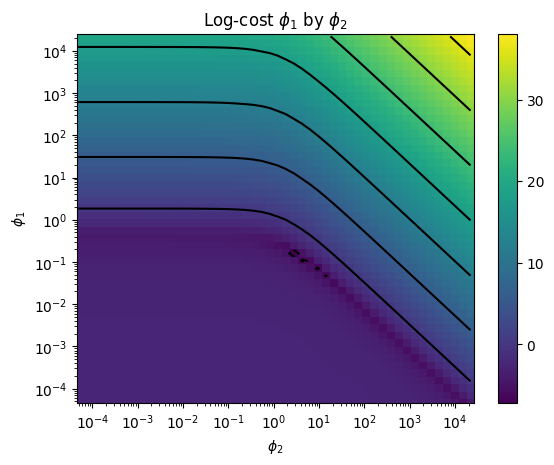

In [9]:
# th1 x th2

plt.contour(*meshg, log_c_tensor[:, :, 25, 25], colors="black")
plt.pcolormesh(*meshg, log_c_tensor[:, :, 25, 25])
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\phi_1$')
plt.xlabel(r'$\phi_2$')
plt.title(f"Log-cost {r'$\phi_1$'} by {r'$\phi_2$'}")


Text(0.5, 1.0, 'Log-cost $\\phi_1$ by $\\phi_3$')

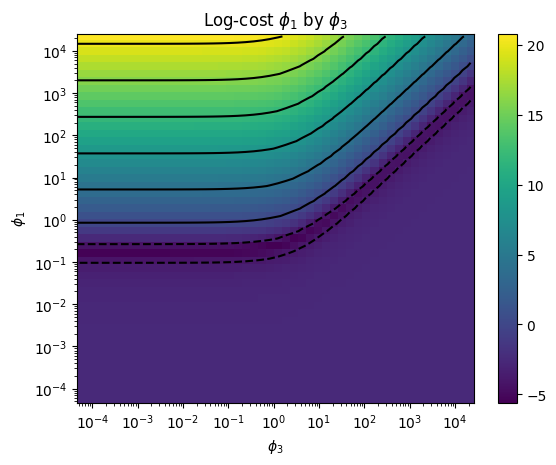

In [10]:
# th1 x th3

plt.contour(*meshg, log_c_tensor[:, 25, :, 25], colors="black")
plt.pcolormesh(*meshg, log_c_tensor[:, 25, :, 25])
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\phi_1$')
plt.xlabel(r'$\phi_3$')
plt.title(f"Log-cost {r'$\phi_1$'} by {r'$\phi_3$'}")

Text(0.5, 1.0, 'Log-cost $\\phi_1$ by $\\phi_4$')

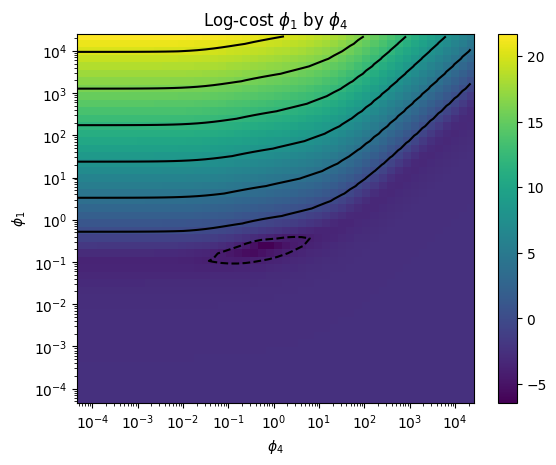

In [11]:
# th1 x th4

plt.contour(*meshg, log_c_tensor[:, 25, 25, :], colors="black")
plt.pcolormesh(*meshg, log_c_tensor[:, 25, 25, :])
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\phi_1$')
plt.xlabel(r'$\phi_4$')
plt.title(f"Log-cost {r'$\phi_1$'} by {r'$\phi_4$'}")

Text(0.5, 1.0, 'Log-cost $\\phi_2$ by $\\phi_3$')

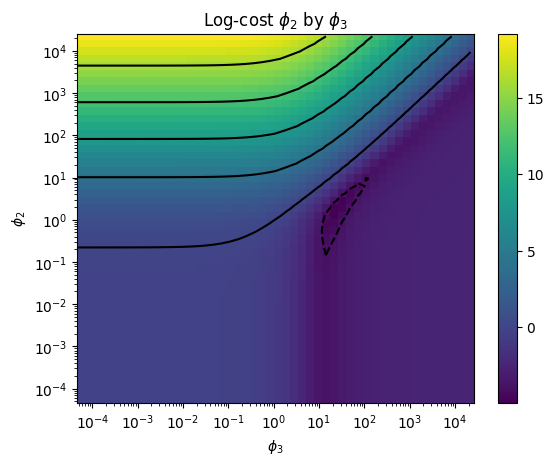

In [12]:
# th2 x th3

plt.contour(*meshg, log_c_tensor[25, :, :, 25], colors="black")
plt.pcolormesh(*meshg, log_c_tensor[25, :, :, 25])
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\phi_2$')
plt.xlabel(r'$\phi_3$')
plt.title(f"Log-cost {r'$\phi_2$'} by {r'$\phi_3$'}")

Text(0.5, 1.0, 'Log-cost $\\phi_2$ by $\\phi_4$')

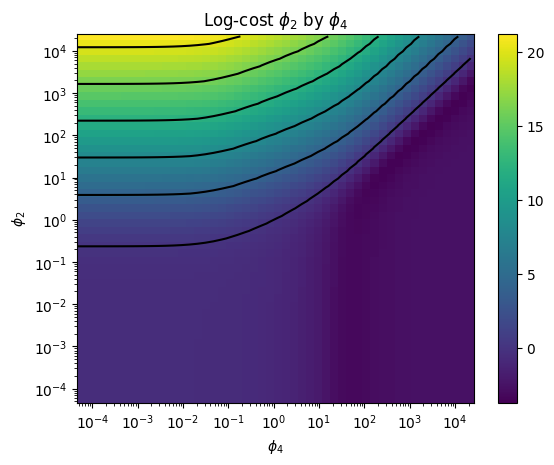

In [13]:
# th2 x th4

plt.contour(*meshg, log_c_tensor[25, :, 25, :], colors="black")
plt.pcolormesh(*meshg, log_c_tensor[25, :, 25, :])
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\phi_2$')
plt.xlabel(r'$\phi_4$')
plt.title(f"Log-cost {r'$\phi_2$'} by {r'$\phi_4$'}")

Text(0.5, 1.0, 'Log-cost $\\phi_3$ by $\\phi_4$')

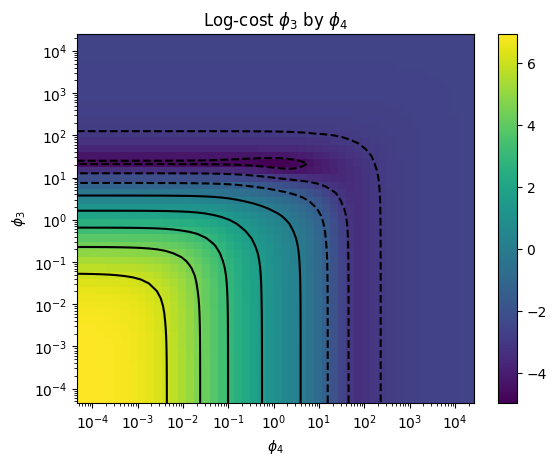

In [14]:
# th3 x th4

plt.contour(*meshg, log_c_tensor[25, 25, :, :], colors="black")
plt.pcolormesh(*meshg, log_c_tensor[25, 25, :, :])
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\phi_3$')
plt.xlabel(r'$\phi_4$')
plt.title(f"Log-cost {r'$\phi_3$'} by {r'$\phi_4$'}")

In [15]:
# e. Identify regions on your cost surface plots which correspond to your simplified models

# simplified models:
# drop th2 (lower left, th1-v-th2)
# drop th3 (lower left, th1-v-th3; lower left, th2-v-th3)
# drop th4 (lower left, th1-v-th4)
# drop th2 & th3 (bottom, th2-v-th3)
# drop th2 & th4 (bottom, th2-v-th4)
# drop th3 & th4 (bottom left, th3-v-th4)
# drop th2 & th3 & th4 (bottom left of all plots except the last)
# ϕ2 >> ϕ1, ϕ1 -> 0 (lower left, th1-v-th2; bottom, th1-v-th3;  bottom, th1-v-th4)
# ϕ3 >> ϕ4, ϕ4 -> 0 (top left, th3-v-th4)
# ϕ4 >> ϕ3, ϕ3 -> 0 (right, th3-v-th4)

In [16]:
# f. Fit the full model to data.(Hint: At the best fit, I find that ϕ1 ≈ 0.2.)

fit = minimize(c, np.array([1, 1, 1, 1]), args=(enzy, rate))
fit.x # this matches ϕ1 ≈ 0.2

array([0.19277051, 0.1922218 , 0.12335622, 0.13646131])

In [17]:
# g. Repeat Part f for each of your simplified models.

def custom_c(theta, enzy, rate, call):
    x_hat = np.array([call(theta, en) for en in enzy])
    diff = x_hat-rate
    norm_d = np.linalg.norm(diff, ord=2)
    return 0.5 * norm_d**2

fits = {}
for call in simplified_callables:
    simple_fit = minimize(custom_c, np.array([1, 1, 1, 1]), args=(enzy, rate, call))
    fits[call.__name__] = simple_fit.x
    print(f"For the simplified model '{call.__name__}', the fit parameters are {simple_fit.x}")

For the simplified model 'f_drop2', the fit parameters are [0.20603113 1.         0.12575824 0.0382867 ]
For the simplified model 'f_drop3', the fit parameters are [0.18305676 0.1607094  1.         0.13823691]
For the simplified model 'f_drop4', the fit parameters are [ 0.21919701 -0.04144616  0.22761978  1.        ]
For the simplified model 'f_drop23', the fit parameters are [0.19230461 1.         1.         0.05722228]
For the simplified model 'f_drop24', the fit parameters are [0.23237847 1.         0.40714765 1.        ]
For the simplified model 'f_drop34', the fit parameters are [ 0.1714469  -0.06759888  1.          1.        ]
For the simplified model 'f_drop234', the fit parameters are [0.09374545 1.         1.         1.        ]
For the simplified model 'f_2morethan1', the fit parameters are [1.5582906  1.5582906  7.45169457 5.02663139]
For the simplified model 'f_3morethan4', the fit parameters are [ 0.21919701 -0.04144616  0.22761978  1.        ]
For the simplified model 'f_

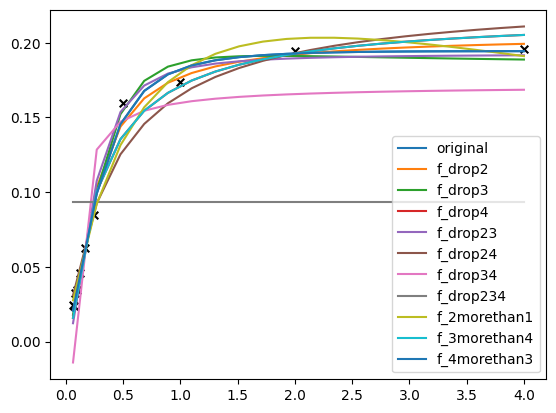

In [18]:
# h. Plot all of your models on the same set of axes with the data. What does this plot tell you
# about the identifiability of this model+parameter combination?

x_plotting = np.linspace(min(enzy), max(enzy), 20)
y_plotting = np.array([f(fit.x, en) for en in x_plotting])
plt.plot(x_plotting, y_plotting, label="original")
for call in simplified_callables:
    y_plotting = np.array([call(fits[call.__name__], en) for en in x_plotting])
    plt.plot(x_plotting, y_plotting, label=call.__name__)
plt.scatter(enzy, rate, color='black', marker="x", s=30)
plt.legend()

# Regarding identifiability of this model+parameter combination, this plot shows that
# there is a lot of signal aliased between parameters such that most can be dropped
# or reduced to a negligible quantity without significant effect on the fit. In other
# words, some parameters are unidentifiable. There are a couple exceptions like
# dropping both parameters in the denominator, or dropping all parameters but theta1,
# but otherwise all other models fit relatively well.

# Acknowledgment
Work in this repository and with associated assignments and projects may be adapted or copied from similar files used in my prior academic and industry work (e.g., using a LaTeX file or Dockerfile as a starting point). Those files and any other work in this repository may have been developed with the help of LLM's like ChatGPT. For example, to provide context, answer questions, refine writing, understand function call syntax, and assist with repetitive tasks. In these cases, deliverables and associated work reflect my best efforts to optimize my learning and demonstrate my capacity, while using available resources and LLM's to facilitate the process.


[ChatGPT Conversation](https://chatgpt.com/share/68f96d9f-e158-8003-a182-d59aa58b4f08)